In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

Bad val "cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])" on line #240
	"axes.prop_cycle    : cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])  # color cycle for plot lines
"
	in file "C:\Users\zhaolei\.matplotlib\matplotlibrc"
	Key axes.prop_cycle: 'cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])' is not a valid cycler construction: invalid syntax (<string>, line 1)


In [5]:
az.style.use('arviz-darkgrid')

## PyMC3 primer

现在，我们对贝叶斯统计有了基本的了解，我们将学习如何使用计算工具来构建概率模型。 具体来说，我们将学习PyMC3的概率编程。 基本思想是使用代码指定模型，然后以或多或少的自动方式解决它们。 这并不是说我们懒得学习数学方法，也不是我们的精英主义者。 这种选择背后的一个重要原因是，许多模型不会导致解析闭合形式，因此我们只能使用数值技术来求解这些模型。

Theano是一个Python库，最初是为深度学习而开发的，它使我们能够有效地定义，优化和评估涉及多维数组的数学表达式。 PyMC3使用Theano的主要原因是因为某些采样方法（例如NUTS）需要计算梯度，并且Theano知道如何使用所谓的自动微分来计算梯度。 此外，Theano将Python代码编译为C代码，因此PyMC3确实非常快。 这是我们需要使用PyMC3的所有有关Theano的信息。您可能已经听说Theano不再开发了，但这没有理由担心。 PyMC开发人员将接管Theano的维护工作，以确保Theano在未来几年内将继续为PyMC3提供服务。 同时，PyMC开发人员正在迅速采取行动，以创建PyMC3的后续产品。 尽管可能也在分析其他选项，但这可能基于TensorFlow作为后端。

In [6]:
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

![title](2_1.png)

For the likelihood, we will use the binomial distribution with and n=1,p=$\theta$, and for the prior, a beta distribution with the parameters
$\alpha=\beta=1$. A beta distribution with such parameters is equivalent to a uniform distribution in the interval [0, 1]. We can write the model using mathematical notation:

In [3]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)  #这是我们告诉PyMC3我们想对已知信息（数据）进行未知处理的方式。
    trace = pm.sample(1000, random_seed=123,cores=1)  #我们要求从后验中获取1,000个样本，并将其存储在跟踪对象中。

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1500/1500 [00:01<00:00, 887.32it/s]


第一和第二行告诉我们，PyMC3已自动分配了NUTS采样器（一个对连续变量非常有效的推理引擎），并使用了一种初始化该采样器的方法。 第三行说PyMC3将并行运行两条链，we will get two independent samples from the posterior for the price of one.。

计算出的确切链数是考虑到计算机中处理器的数量的，您可以使用样本函数的chains参数来更改它。 下一行告诉我们哪个采样器正在采样哪个变量。 对于这种特殊情况，此行不会添加新信息。 因为使用NUTS来采样唯一的变量，所以我们有θ。 但是，并非总是如此，因为PyMC3可以将不同的采样器分配给不同的变量。 PyMC3根据变量的属性自动完成此操作，以确保为每个变量使用最佳采样器。 用户可以使用sample函数的step参数手动分配采样器。

最后，最后一行是进度条，带有几个相关的指标，指示采样器的工作速度，包括每秒的迭代次数。 如果运行代码，您将看到进度条的更新非常快。 在这里，我们看到了采样器完成工作的最后阶段。 数字是3000/3000，其中第一个数字是运行中的采样器编号（此数字从1开始），最后一个是采样总数。 您会注意到我们已经要求提供1,000个样本，但是PyMC3正在计算3,000个样本。 每个链上有500个样本以自动调整采样算法（在本示例中为NUTS）。 默认情况下，此样本将被丢弃。 我们每条链上还有1000个生产性抽签，因此总共生成了3,000个样本。 调整阶段可帮助PyMC3从后部提供可靠的样本。 我们可以使用样本函数的tune参数更改调整步骤的数量。

### Summarizing the posterior

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


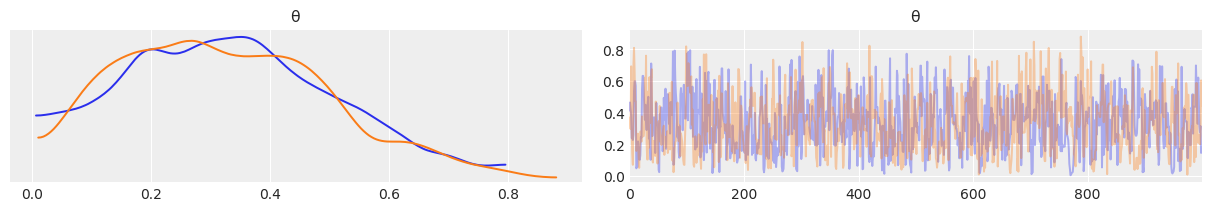

In [5]:
az.plot_trace(trace)
plt.savefig('B11197_02_01.png')

我们模型中唯一未观察到的变量是$\theta$。 注意，y是表示数据的观察变量； 我们不需要进行采样，因为我们已经知道这些值。 因此，在图2.1中，我们有两个子图。 在左边，我们有一个内核密度估计（KDE）图。 这就像直方图的平滑版本。 在右侧，我们在采样过程中的每一步都获得了单独的采样值。 从轨迹图中，我们可以从后部直观地获得合理的值。 您应该将PyMC3的结果与上一章的分析结果进行比较。

In [6]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.333,0.176,0.02,0.635,0.006,0.004,851.0,851.0,816.0,834.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024E7D68AB38>,
      dtype=object)

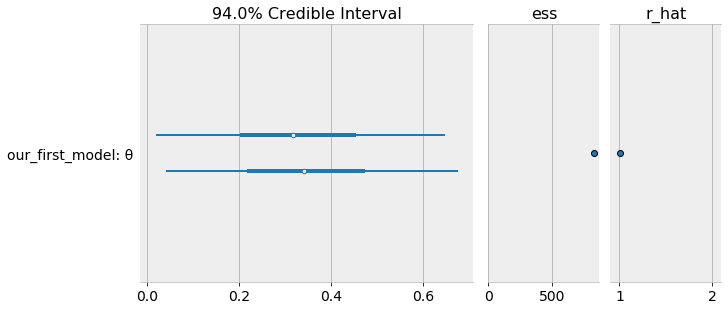

In [4]:
az.plot_forest(trace, model_names=['our_first_model'],
               var_names=['θ'], r_hat=True,ess=True)

In [5]:
az.ess(trace)['θ'].values

array(827.30252666)

#### Posterior-based decisions

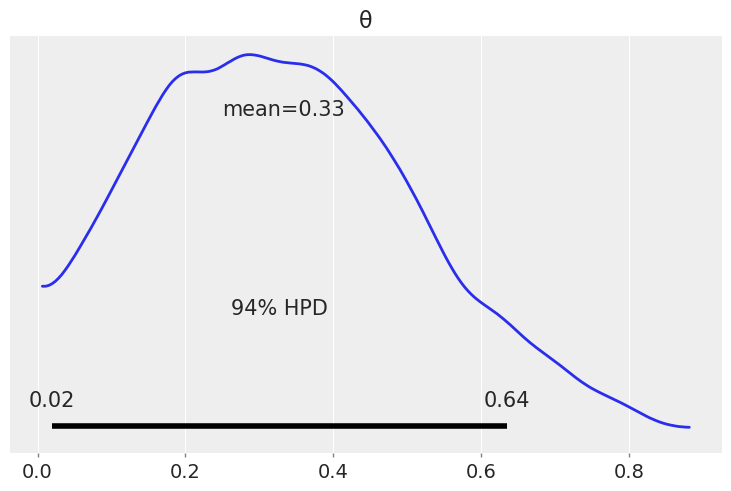

In [7]:
az.plot_posterior(trace)
plt.savefig('B11197_02_02.png', dpi=300)

我们可能需要确定硬币是否公平。 一个公平的硬币是一个值正好为0.5的硬币。 我们可以将0.5的值与HPD间隔进行比较。 在图2.2中，我们可以看到HPD从≈0.02变为≈0.71，因此HPD中包含0.5。 根据我们的后验，硬币似乎偏向尾部，但我们不能完全排除硬币是公平的可能性。 如果我们想做出更明智的决定，我们将需要收集更多的数据以减少后验的传播，或者我们可能需要找出如何定义一个更具信息量的先验。

严格来说，精确观测0.5（即无限的尾随零）的机会为零。 而且，实际上，我们通常不关心确切的结果，而是在一定范围内的结果。 因此，实际上，我们可以放宽对公平性的定义，可以说公平硬币是价值约为0.5的硬币。 例如，对于我们来说，可以说间隔[0.45，0.55]中的任何值实际上等于0.5。 我们将此间隔称为实际等效区域（ROPE:是我们根据背景知识选择的任意间隔。 假定此间隔内的任何值都是等效的。）。 定义ROPE之后，我们将其与最高后密度（HPD）进行比较。 我们至少可以得到三种情况：

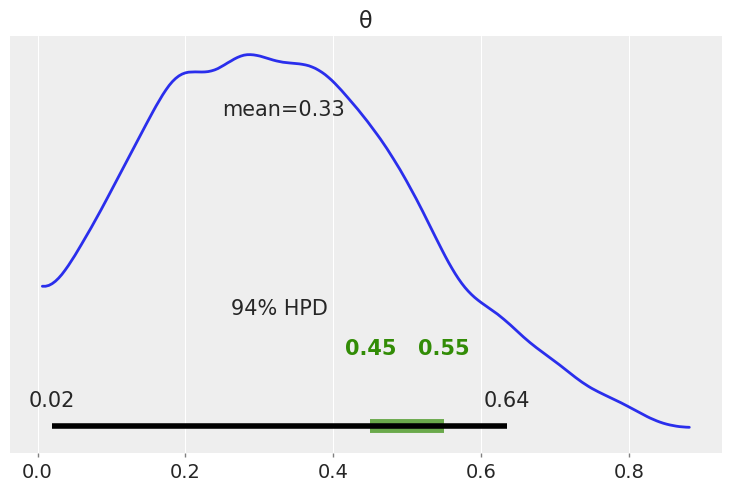

In [8]:
az.plot_posterior(trace, rope=[0.45, .55])
plt.savefig('B11197_02_03.png', dpi=300)

ROPE与HPD不重叠； 我们可以说硬币不公平
ROPE包含整个HPD； 我们可以说硬币很公平
ROPE与HPD部分重叠； 我们不能说硬币是公平的还是不公平的

如果我们在[0，1]区间内选择ROPE，我们总是会说我们有一个公平的硬币。 注意，我们不需要收集数据即可执行任何类型的推断。 当然，这是一个琐碎，不合理和不诚实的选择，而且可能没人会同意我们的ROPE定义。 我仅提及它是为了强调ROPE的定义取决于上下文的事实。 没有自动魔术规则可以满足每个人的意图。 决策本质上是主观的，我们的使命是根据我们的目标做出最明智的决策。

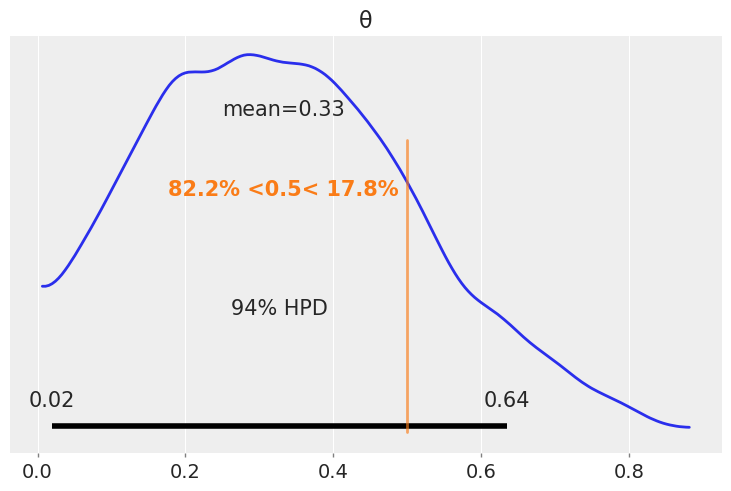

In [9]:
az.plot_posterior(trace, ref_val=0.5)
plt.savefig('B11197_02_04.png', dpi=300)

#### 损失函数

为了做出正确的决定，重要的是要使相关参数的估计值具有尽可能高的精确度，但考虑到犯错的成本也很重要。 成本/收益权衡可以使用损失函数在数学上形式化。 损失函数或其逆函数的名称在不同的字段中有所不同，我们可以找到诸如成本函数，目标函数，适应度函数，效用函数等之类的名称。 无论名称如何，关键思想是使用一个函数来捕获参数的真实值和估计值有多大差异。 损失函数的值越大，估计就越差（根据损失函数）。

我知道这不是正式的证明，但请注意这：不同的损失函数与不同的点估计有关。

好的，因此，如果我们要形式化并且要计算单个点估计，则必须决定要使用哪个损失函数，反之，如果选择给定的点估计，则我们是隐式的（甚至可能是无意识的） ）决定损失函数。明确选择损失函数的优势在于，我们可以针对问题调整函数，而不是使用某些不适用于我们特定情况的预定义规则。例如，在许多问题中，决策的成本是不对称的。决定为五岁以下的儿童接种疫苗是正确的还是错误的，要决定是否安全是不一样的。做出错误的决定可能会丧生数以千计的生命，并可能引发健康危机，而通过管理廉价，安全的疫苗可以避免这种情况。因此，如果我们的问题需要它，我们可以构造一个不对称损失函数。还需要注意的是，由于后验是数字样本的形式，因此我们可以计算复杂的损失函数，这些函数无需受到数学上的便利或简单性的限制。

话虽如此，我想澄清一点。 并非每当人们使用点估计时，他们就损失函数进行了真正的思考。 实际上，在我或多或少熟悉的许多科学领域中，损失函数并不是很常见。 人们通常选择中位数，仅仅是因为它比均值对离群值更鲁棒，或者仅仅因为是一个简单而熟悉的概念而使用中位数，或者是因为他们认为自己的可观测值实际上是某个过程的平均水平，例如分子 彼此反弹或与自身和环境相互作用的基因。

我们刚刚看到了关于损失函数的非常简短和肤浅的介绍。 如果您想更多地了解这一点，可以尝试阅读决策理论，这是研究形式决策的领域。

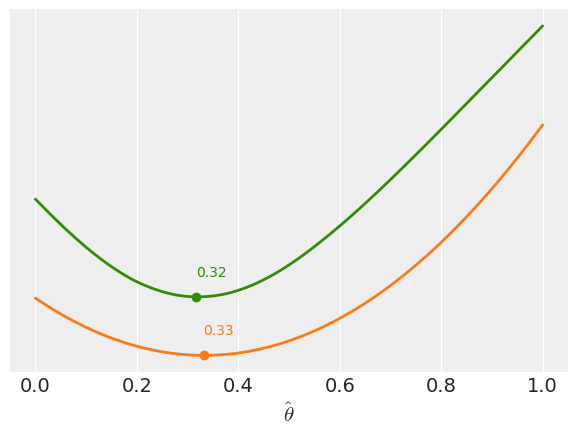

In [10]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C2', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.04), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_05.png', dpi=300)

In [11]:
np.mean(θ_pos), np.median(θ_pos)

(0.3327974201215023, 0.3191780533242572)

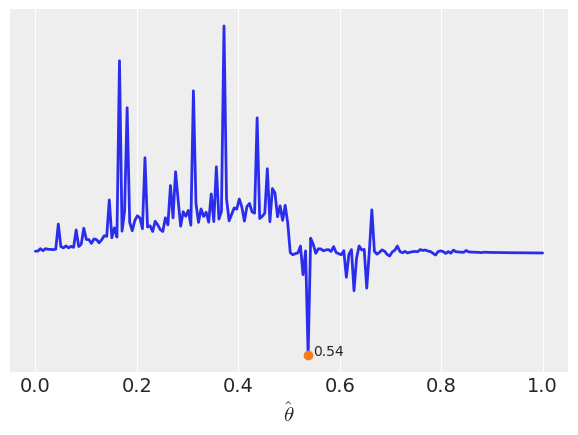

In [12]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_06.png', dpi=300)

## Gaussian inferences

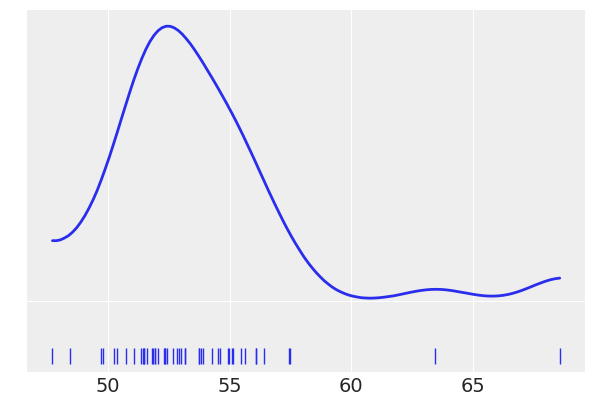

In [7]:
data = np.loadtxt('../data/chemical_shifts.csv')

# remove outliers using the interquartile rule
#quant = np.percentile(data, [25, 75])
#iqr = quant[1] - quant[0]
#upper_b = quant[1] + iqr * 1.5
#lower_b = quant[0] - iqr * 1.5
#data = data[(data > lower_b) & (data < upper_b)]
#print(np.mean(data), np.std(data))

az.plot_kde(data, rug=True)  #, rug=True 标注数据分布
plt.yticks([0], alpha=0)
plt.savefig('B11197_02_07.png', dpi=300)

标准偏差为的半正态分布。 半正态分布类似于正态正态分布，但仅限于正值（包括零）。 您可以通过从正态分布中采样然后取每个采样值的绝对值来从半正态中获取样本。 

 <img src="B11197_02_08.png" width="500">

In [8]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:13<00:00, 216.34draws/s]


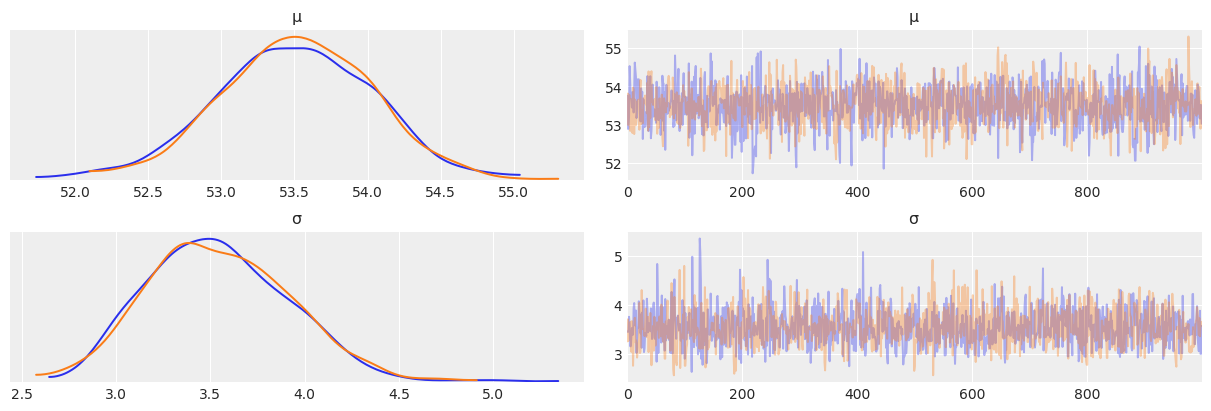

In [9]:
az.plot_trace(trace_g)
plt.savefig('B11197_02_09.png', dpi=300)

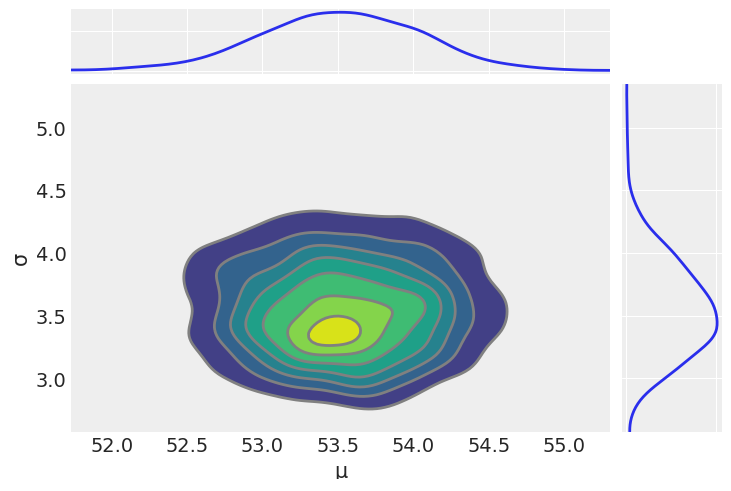

In [10]:
az.plot_joint(trace_g, kind='kde', fill_last=False)
plt.savefig('B11197_02_10.png', dpi=300)

In [11]:
trace_g['σ'] 

array([3.4555476, 3.4605062, 3.4605062, ..., 3.583427 , 3.575449 ,
       3.6578355], dtype=float32)

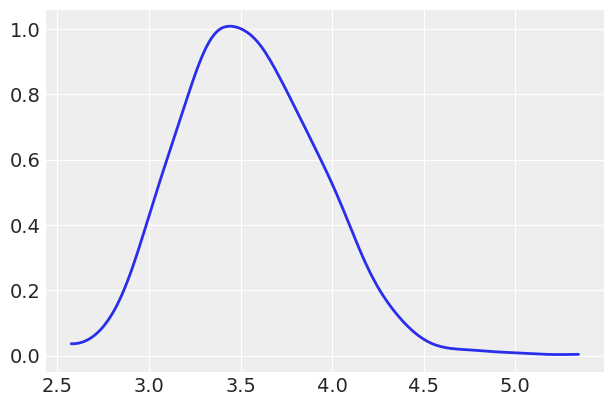

In [12]:
az. plot_kde(trace_g['σ' ] )

In [13]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.507,0.525,52.429,54.41,0.014,0.010,1450.0,1450.0,1463.0,1025.0,1.00
σ,3.549,0.376,2.900,4.23,0.009,0.006,1684.0,1673.0,1659.0,1229.0,1.01


In [20]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 430.28it/s]


1

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


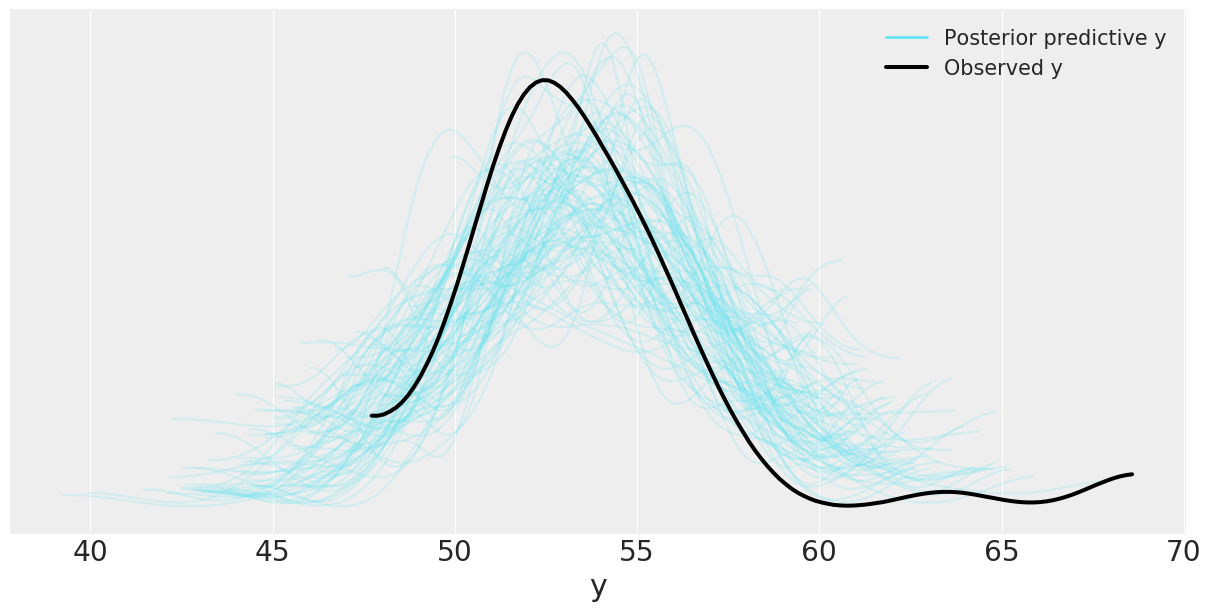

In [15]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)  #Convert pymc3 data into an InferenceData object.
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)   #Plot for posterior/prior predictive checks.
ax[0].legend(fontsize=15)
plt.savefig('B11197_02_11.png', dpi=300)

从图2.11中可以看到，模拟数据的平均值向右稍微偏移，并且模拟数据的方差似乎比实际数据大。 这是将两个观测值与大量数据分开的直接结果。 我们可以使用该图来自信地说该模型有故障并且需要更改吗？ 好吧，与往常一样，模型的解释及其评估取决于上下文。 根据我对这些类型的度量的经验以及我通常使用此数据的方式，我会说此模型可以足够合理地表示数据，并且对我的大多数分析很有用。 尽管如此，在下一节中，我们将学习如何优化model_g并获得与数据更接近的预测。

### Robust inferences

一种选择是将这些点声明为离群值并将其从数据中删除。 我们可能有正当理由丢弃这些点，例如在测量这两个数据点时设备故障或人为错误。 有时，我们甚至可以修复这些数据点，例如，如果我们意识到它们只是清理数据时编码错误的结果。 在许多情况下，我们可能还想通过使用许多异常值规则之一来自动化异常值消除过程。 其中两个是：
任何低于下四分位间距的1.5倍或上四分位间距的1.5倍的数据点都是异常值
任何低于或高于标准偏差两倍的数据点都应声明为离群值并从我们的数据中清除

通常，贝叶斯算法倾向于通过使用不同的先验和可能性将假设直接编码到模型中，而不是通过异常启发式规则（例如离群值移除规则）将假设编码到模型中。

处理离群值和高斯分布时，一个非常有用的选择是用学生的t分布代替高斯似然。此分布具有三个参数：平均值，比例（类似于标准偏差）和自由度（通常使用希腊字母表示），它们可以在区间[0，∞]中变化。遵循Kruschke的术语，我们称其为正态性参数，因为它负责控制学生t分布的正态性。对于的值，我们得到一个尾部很重的分布，也称为柯西分布或洛伦兹分布。这个姓氏在物理学家中特别受欢迎。粗尾意味着我们比高斯更有可能找到远离均值的值，换句话说，值不像高斯那样在较轻的尾部分布中集中在均值附近。例如，柯西分布的95％的值位于-12.7和12.7之间。相反，对于高斯（标准偏差为1），这发生在-1.96和1.96之间。在参数空间的另一侧，当逼近无穷大时，我们恢复了高斯分布（您不能比正态分布更正态，对吗？）。学生t分布的一个非常奇怪的特征是，它在when时没有定义的均值。当然，实际上，来自学生t分布的任何有限样本都是一堆数字，始终可以从中计算出经验均值。理论分布本身就是没有定义均值的分布吗？从直觉上讲，这可以理解为：分布的尾巴很重，以至于在任何时候都可能从实线的几乎任何地方获取采样值，因此，如果我们不断获取数字，我们将永远不会近似于固定值。

In [22]:
np. mean(stats. t(loc=0, scale=1, df=1000) . rvs(100) )

0.05116546050630863

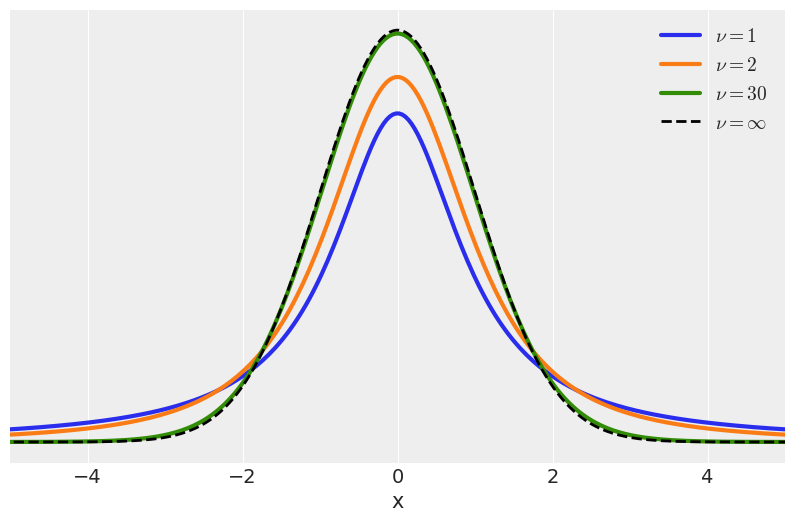

In [23]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png', dpi=300)

由于学生的t分布的参数（v）比高斯分布的参数多，因此我们需要先指定一个参数v。 我们将设置为平均数为30的指数分布。从图2.12中可以看出，学生的t分布看起来与高斯非常相似（即使不是）。 实际上，从同一张图中，我们可以看到，大多数动作是针对的较小值发生的。 因此，我们可以说平均数为30的指数先验是一个弱信息先验，告诉我们或多或少认为该模型应在30左右，但可以轻松移至越来越小的值。 在许多问题中，估算并不直接重要。 以图形方式，我们有：

 <img src="B11197_02_13.png" width="500">

In [24]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)   #λ=1/df
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, μ]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:07<00:00, 417.72draws/s]


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

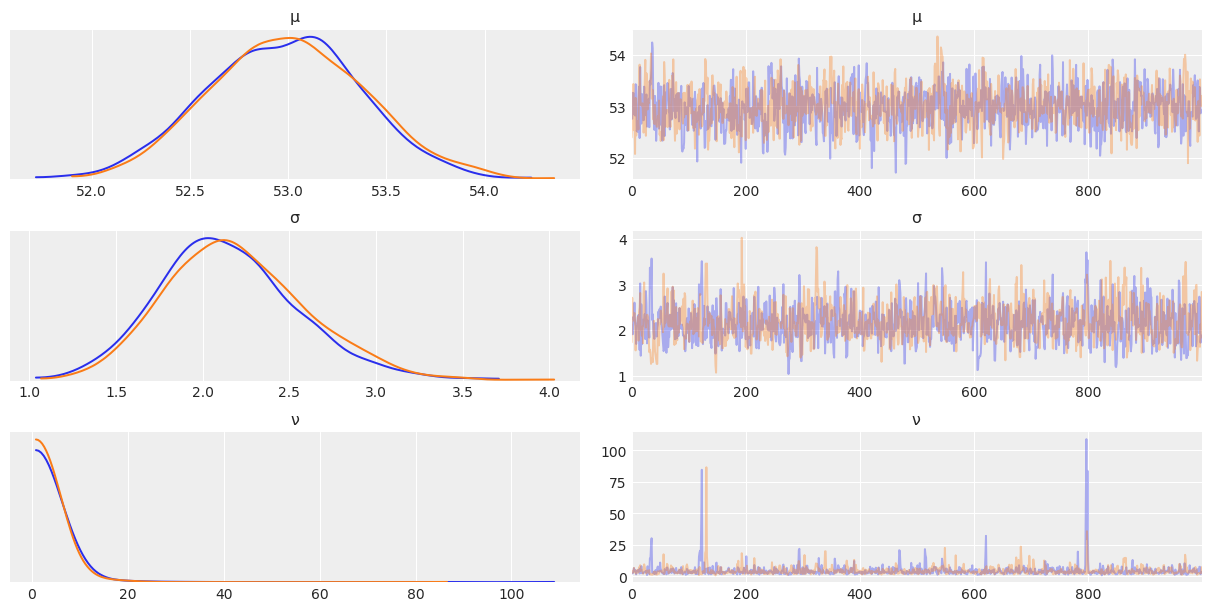

In [25]:
az.plot_trace(trace_t)
plt.savefig('B11197_02_14.png', dpi=300)

In [26]:
az.summary(trace_t)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,52.990,0.389,52.273,53.729,0.011,0.008,1178.0,1176.0,1171.0,950.0,1.0
σ,2.174,0.407,1.499,3.006,0.013,0.009,1004.0,991.0,1011.0,775.0,1.0
ν,4.633,5.193,1.324,9.070,0.189,0.133,759.0,759.0,1126.0,975.0,1.0


两个模型之间的估计相似，相差≈0.5。 估计从≈3.5到≈2.1的变化。 这是由于学生的t分布通过远离均值的值赋予了较小的权重（减轻了震动）。 我们还可以看到，即我们的分布不是很像高斯分布，而是尾巴较重。

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 856.99it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


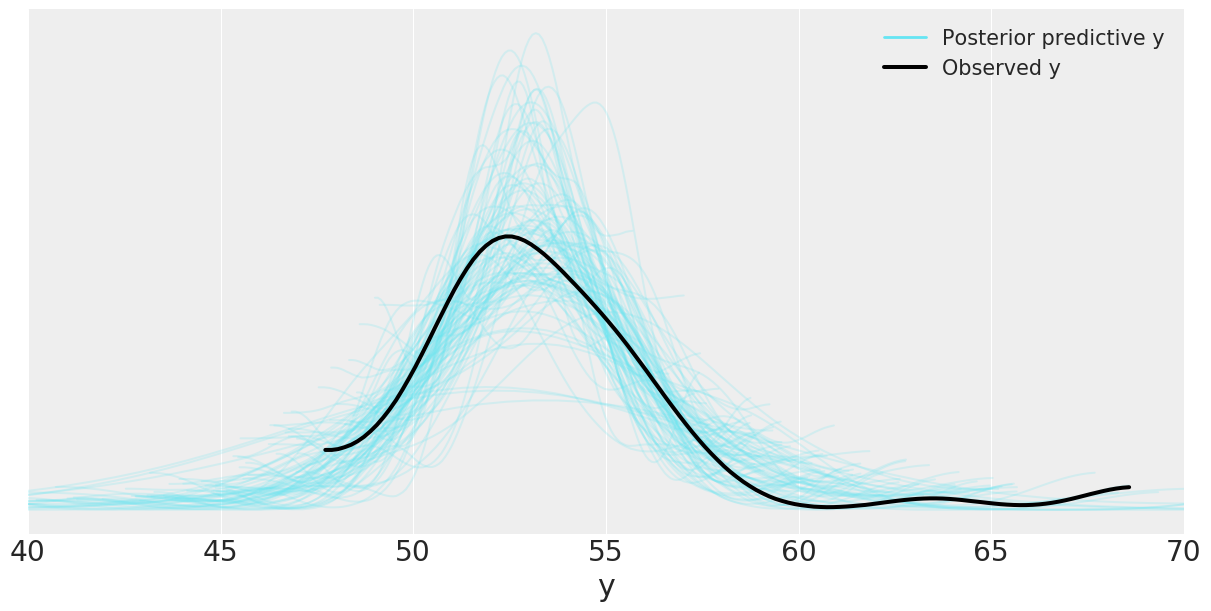

In [27]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
plt.legend(fontsize=15)
plt.xlim(40, 70)
plt.savefig('B11197_02_15.png', dpi=300)

学生的t分布使我们可以进行更可靠的估计，因为离群值具有减小v的作用，而不是向其移动均值并增加标准差。 因此，通过对大量数据中的数据点进行加权来估计平均值和scale类似标准差，而不是对其进行加权。 再一次，重要的是要记住scale不是标准偏差。 然而，scale与数据的分散程度有关。 其值越低，分布越集中。 同样，对于的v值>=2，scale的值往往非常接近（至少出于大多数实际目的）与除去异常值之后估算的值。 因此，根据经验，对于v不太小的值，并考虑到理论上并不完全正确，我们可以考虑将学生t分布的scale作为数据除去异常值后标准偏差的合理实用替代。 

### 分组比较
一种非常常见的统计分析是组比较。 我们可能感兴趣的是患者对某种药物的反应良好，通过采用新的交通法规减少交通事故，在不同教学方法下的学生表现等等。

有时，此类问题是在假设检验方案下进行的，目的是声明结果具有统计学意义。 由于许多原因，仅依靠统计意义是有问题的：一方面，统计意义不等于实际意义；另一方面，统计意义不等于实际意义。 另一方面，仅通过收集足够的数据就可以声明很小的影响。 假设检验的概念与p值的概念有关。 这不是基本的联系，而是文化上的联系。 人们习惯了这种思维方式，主要是因为这是他们在大多数入门统计学课程中所学的内容。 有大量的研究和论文记录表明，p值经常被使用和错误地解释，即使每天使用它们的人也是如此。

与其进行假设检验，不如采取另一条路线，而是着重估计效应大小effect size，即量化两组之间的差异。 根据效果大小进行思考的优点之一是，我们摆脱了诸如是或否这样的问题。 它有效吗？，有效果吗？ 诸如此类的更细微差别的问题； 效果如何？ 效果有多大/小？

有时，在比较各组时，人们会谈论一个对照组和一个治疗组（或可能不止一个对照组和治疗组）。 例如，当我们要测试一种新药时，这是有道理的：由于安慰剂作用和其他原因，我们要将该新药（治疗方法）与对照组（未接受该药物的组）进行比较。 在这种情况下，我们想知道一种药物与不进行任何操作（或通常对付安慰剂作用）相比效果如何。 一个有趣的替代问题是，要问一种新药与（已经批准的）最流行的药物相比有多好。 在这种情况下，对照组不能是安慰剂。 应该是其他药物。 伪造对照组是利用统计数据撒谎的一种绝妙方式。

例如，假设您在一家乳制品公司工作，该公司想通过告诉孩子的父亲和母亲这种特殊的酸奶增强免疫力或帮助孩子长大，从而向孩子们出售含糖过多的酸奶。 欺骗和错误地用数据备份您的主张的一种方法是使用牛奶或什至是水作为对照组，而不是另一种便宜，少糖，少销售的酸奶。 当我这样说时，听起来可能很愚蠢，但是通过这种方式进行了很多实际的研究。 实际上，我描述的是实际论文，而不是假想的假设情景。 当有人说某件事变得更难，更好，更快，更强时，请记住问比较所用的基准是什么。

要比较组，我们必须确定要用于比较的一个或多个特征。 一个非常普遍的特征是每组的平均值。 因为我们是贝叶斯算法，所以我们将努力获得组间均值差异的后验分布，而不仅仅是差异的点估计。 为了帮助我们查看和解释这种后验，我们将使用三种工具：
##### A posterior plot with a reference value

![title](2_2.png)

##### The Cohen's d (Cohen's d 是一种衡量效应大小的方法，其中均值的差异通过考虑两组的标准偏差汇总来标准化。)

![title](2_3.png)

根据该表达式，效果大小是相对于两组的合并标准差的均值之差。 因为我们可以获得均值和标准差的后验分布，所以我们可以计算Cohen d值的后验分布。 当然，如果我们只需要或想要一个值，则可以计算该后验分布的均值并获得一个Cohen d值。 通常，在计算合并的标准偏差时，我们会明确考虑每组的样本量，但是以前的公式忽略了两组的样本量。 原因是我们从后验得到标准偏差的值，因此我们已经在考虑标准偏差的不确定性。Cohen d通过使用每个组的标准偏差来介绍每个组的变异性。 这一点非常重要，因为标准偏差为0.1时，与标准偏差为10时相比，相差较大。另外，每个数据点都可以解释单位从一组到另一组的变化。 精确地更改单位，或者一半更改不变，另一半更改单位，以及许多其他组合。 因此，包括组的内在变化是一种将差异置于上下文中的方法。 重新衡量（标准化）差异有助于我们理解不同组之间差异的重要性，即使我们对测量所用的规模不太熟悉。(Cohen的d可解释为Z分数（标准分数）。 Z分数是标准偏差的有符号数，其标准差与该值的平均值不同于所观察或测量的平均值。 因此，Cohen值为0.5可以解释为一组相对于另一组的标准差为0.5。)

即使均值差异已标准化，我们仍然可能需要根据给定问题的上下文进行自我校准，以便能够确定给定值是大，小，中等。 幸运的是，可以通过足够的实践来获得此校准。 举个例子，如果我们习惯于对几乎相同类型的问题进行多次分析，那么我们就可以习惯于说1的科恩定律，因此当我们得到说2的科恩定律时，我们知道 重要的事情（或某人在某个地方犯了错误！）。 如果您还没有这样做，可以向领域专家咨询他们的宝贵意见。http://rpsychologist.com/d3/cohend 是一个非常不错的网页，用于探讨Cohen d的不同值。。 在该页面上，您还将找到表达效果大小的其他方法。 其中一些可能更直观，例如优势概率，我们将在后面讨论。

##### The probability of superiority
这是报告效果大小的另一种方法，并且定义为从一组随机获取的数据点比从另一组随机获取的数据点更大的概率。 如果我们假设所使用的数据是正态分布的，则可以使用以下表达式从科恩d计算优势概率：

![title](2_4.png)

在这里，$\phi$是累积正态分布，$\delta$是Cohen'd。 我们可以计算优势概率的点估计（通常会报告什么），也可以计算值的整体后验分布。 如果我们对正态性假设表示满意，则可以使用此公式从Cohen'd中获得优势概率。 否则，因为我们有来自后验的样本，所以我们可以直接对其进行计算（请参阅“练习”部分）。 这是使用马尔可夫链蒙特卡洛（MCMC）方法的一个很好的优势。 一旦我们从后验中获取样本，就可以从中计算出很多数量。

# Tips example

In [28]:
tips = pd.read_csv('../data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


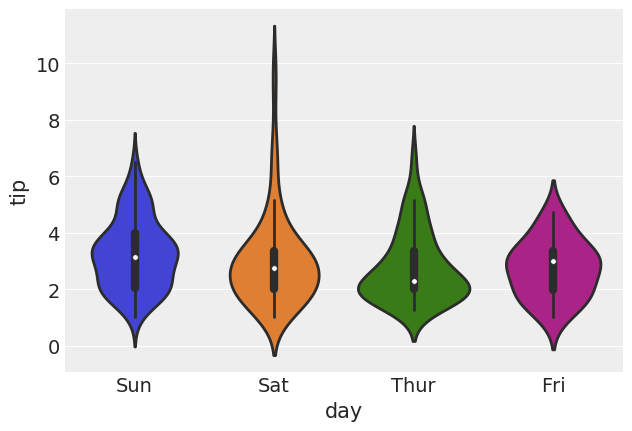

In [29]:
sns.violinplot(x='day', y='tip', data=tips)
plt.savefig('B11197_02_16.png', dpi=300)

In [30]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [31]:
idx 

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0], dtype=int8)

In [32]:
xxx=pd.Categorical( [1,'a',2,3,'a','b',2] ).codes 

这个问题的模型与model_g几乎相同； 唯一的区别是，现在并且将要成为向量而不是标量变量PyMC3语法在这种情况下非常有用：我们可以以向量化的方式编写模型，而不是编写循环。 这意味着对于先验，我们传递一个形状参数，对于似然，我们使用idx变量正确索引均值和sds变量：

##### pd.Categorical(tips['day'],categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
其实看到这里 可以发现 Categorical 的功能和 之前在机器学习 数据处理部分提到的 LabelEncoder的功能是一样的， 不过 Categorical 是对自己编码 ，而LabelEncoder 是通过通过一个样本 制成标准 然后 对其他样本编码，因而相对的更加灵活。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████████████████████████████████| 11000/11000 [00:15<00:00, 703.72draws/s]
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwa

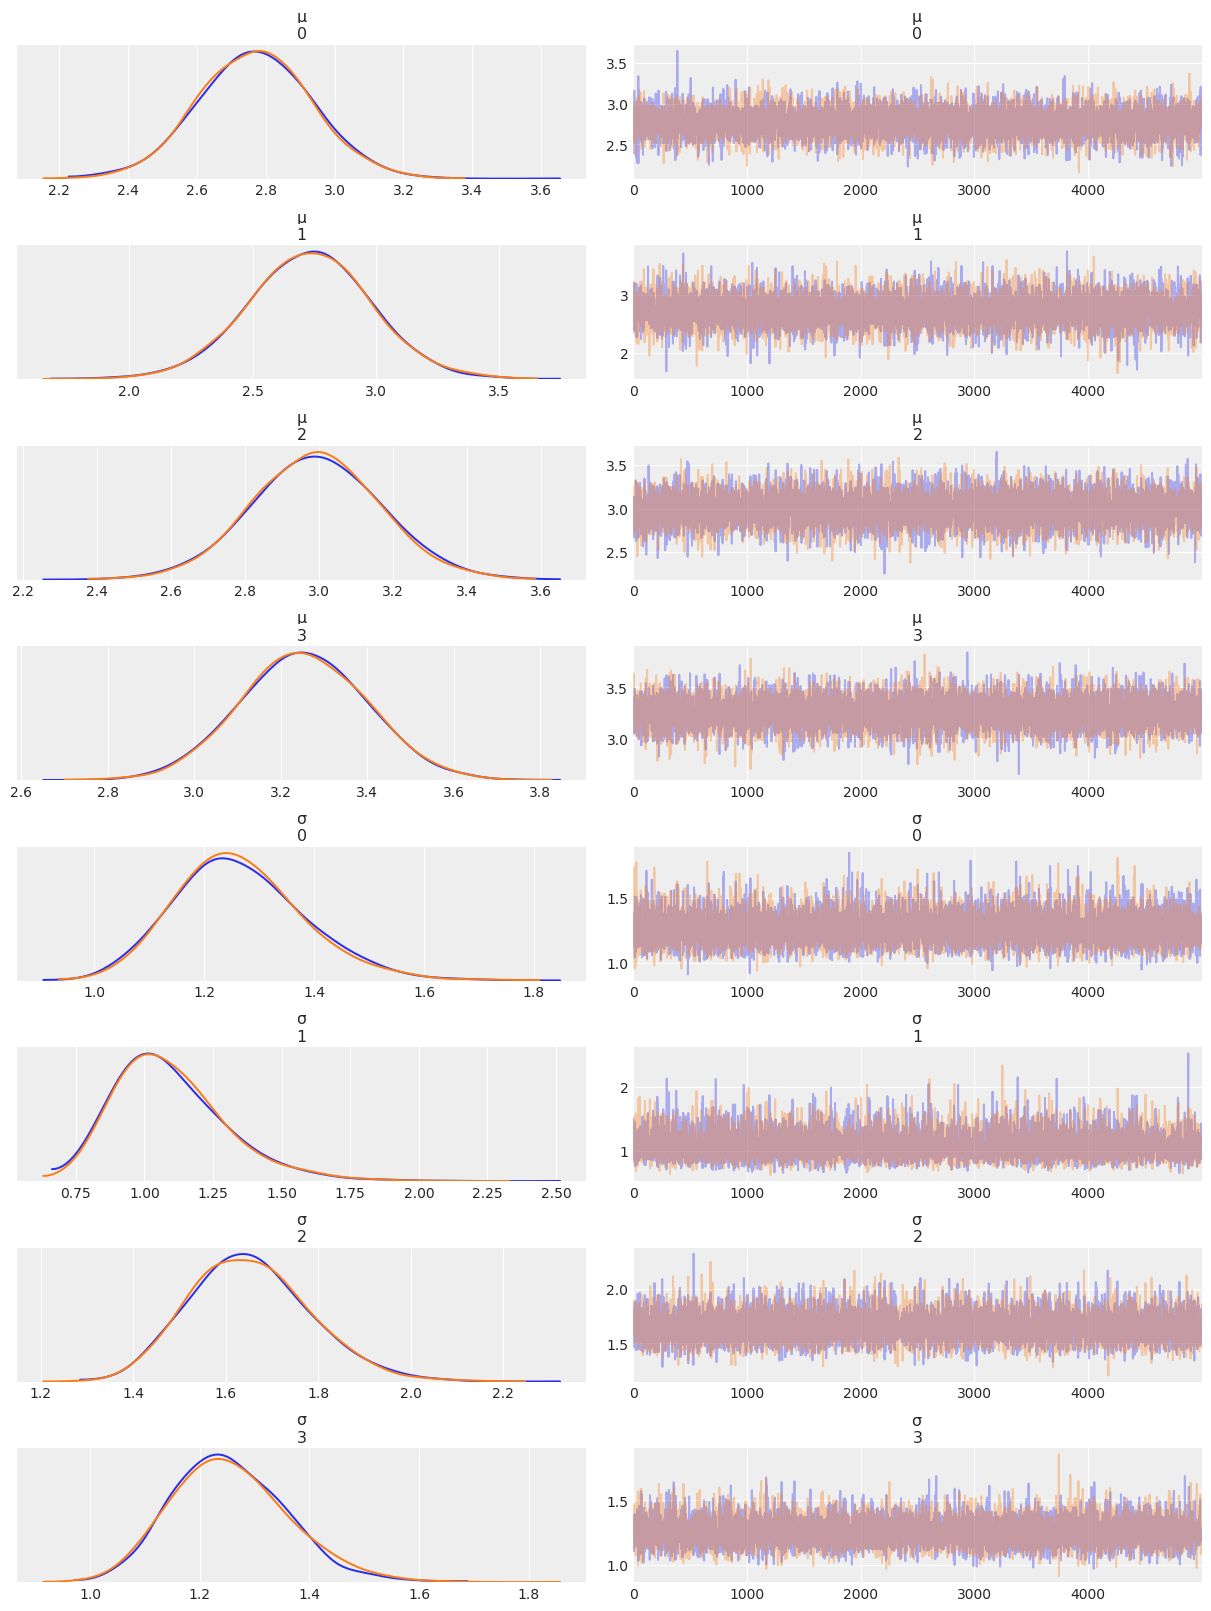

In [33]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)
plt.savefig('B11197_02_17.png', dpi=300)

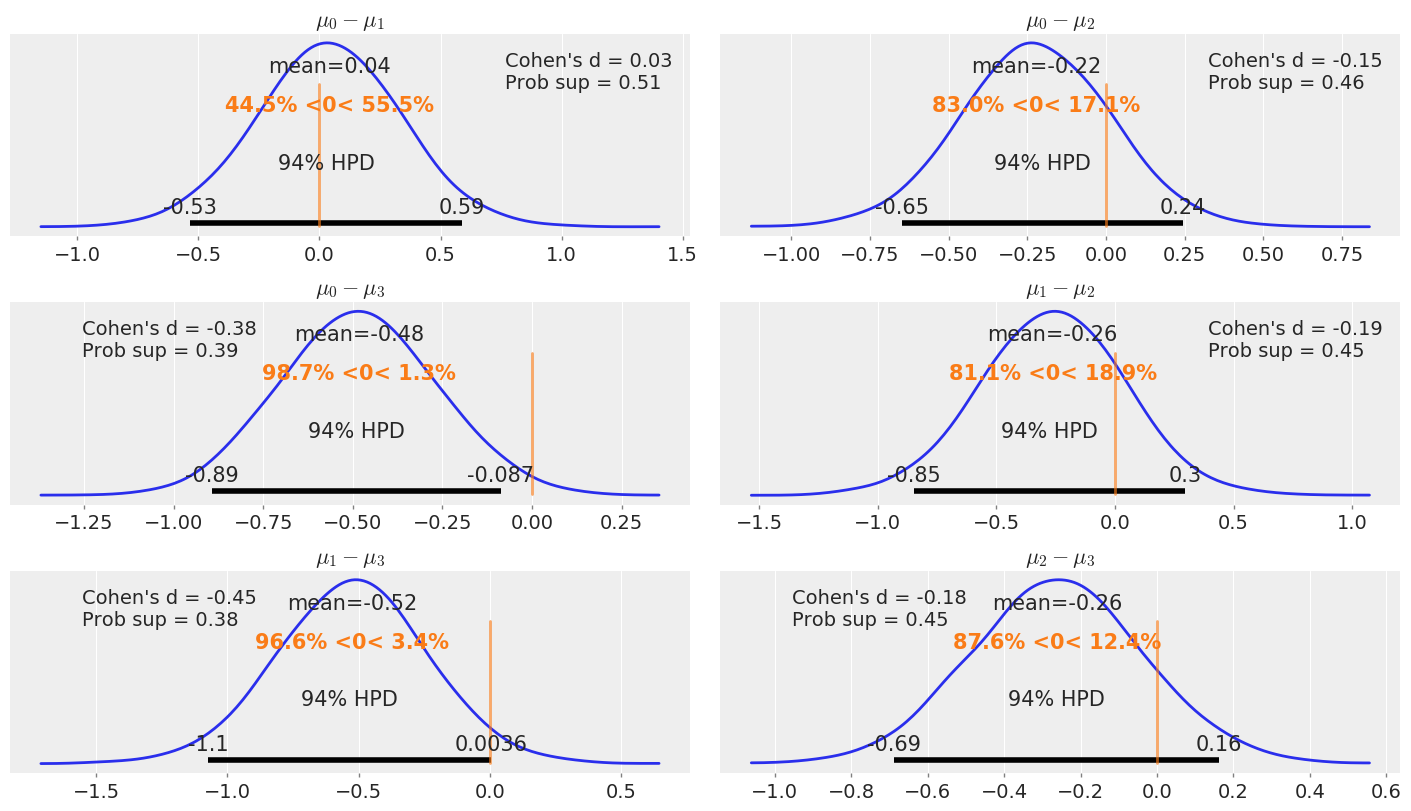

In [34]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

解释这些结果的一种方法是将参考值与HPD间隔进行比较。 根据前面的图表，当94％HPD排除参考值零（即，周四和周日之间的提示差）时，只有一种情况。 对于所有其他示例，我们不能排除零差（根据HPD参考值重叠标准）。 但是即使那样，≈0.5美元的平均差额也足够大吗？ 这种差异是否足以接受周日的工作，却错过了与家人或朋友共度时光的机会？ 这种差异是否足以证明在四天内平均小费并为每位女服务员和服务员提供相同数量的小费？ 这类问题无法通过统计来回答； 它们只能通过统计信息得知。

图3,5都是prob sup小，从一组随机获取的数据点比从另一组随机获取的数据点更大的概率必然小

# Hierarchical Models
不宜建立太多层次的模型，这样不利于理解。构建模型的主要思想是理解数据，因此模型应反映（并利用）数据中的结构。

该模型实质上与我们用于硬币问题的模型相同，但有两个重要特征：
我们已经定义了两个将影响beta优先级的超优先级。
而不是将超优先级放在参数$\alpha$和$\beta$上，我们根据β分布的平均值$\mu$和β分布的精度$\kappa$（浓度）间接定义它们。 精度类似于标准偏差的倒数。$\kappa$ 的值越大，beta分布将越集中：

请注意，我们使用子索引来指示该模型的某些参数组具有不同的值。 即，并非所有参数都在组之间共享。 使用Kruschke图，很明显，与到目前为止我们看到的所有模型相比，该新模型都具有更高的层次：

请注意，在图2.19中，一旦知道并且$\mu$和$\kappa$的值完全确定，我们如何使用符号=而非〜来定义$\alpha$和$\beta$。 因此，我们将这种类型的变量称为确定性变量，与诸如$\mu$，$\theta$或$\kappa$的随机变量相对。

让我们来谈谈参数化。 在数学上，使用均值和精度等同于使用$\alpha$和$\beta参数化，这意味着我们应该获得相同的结果。 那么，为什么我们走这条弯路而不是更直接的路线？ 有两个原因：

首先，均值和精度参数化虽然在数学上是等效的，但在数值上更适合采样器，因此我们对PyMC3返回的结果更有信心，我们将在第8章“推断”中了解此语句的原因和直觉。

第二个原因是教学方法。 这是一个具体示例，显示了可能存在不止一种表达模型的方式。 在数学上等效的实现可能仍然存在实际差异。 采样器的效率是要考虑的一个方面，而另一方面可能是模型的可解释性。 对于某些特定问题或特定受众，与和参数相比，报告beta分布的均值和精度可能是一个更好的选择。

 <img src="B11197_02_19.png" width="500">

In [2]:
N_samples = [30, 30, 30]
G_samples = [18, 3, 3]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
#生成了3组数据，每组30个，对应三个水源。G代表优质

In [3]:
group_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [7]:
np.array(data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [49]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:12<00:00, 401.58draws/s]


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

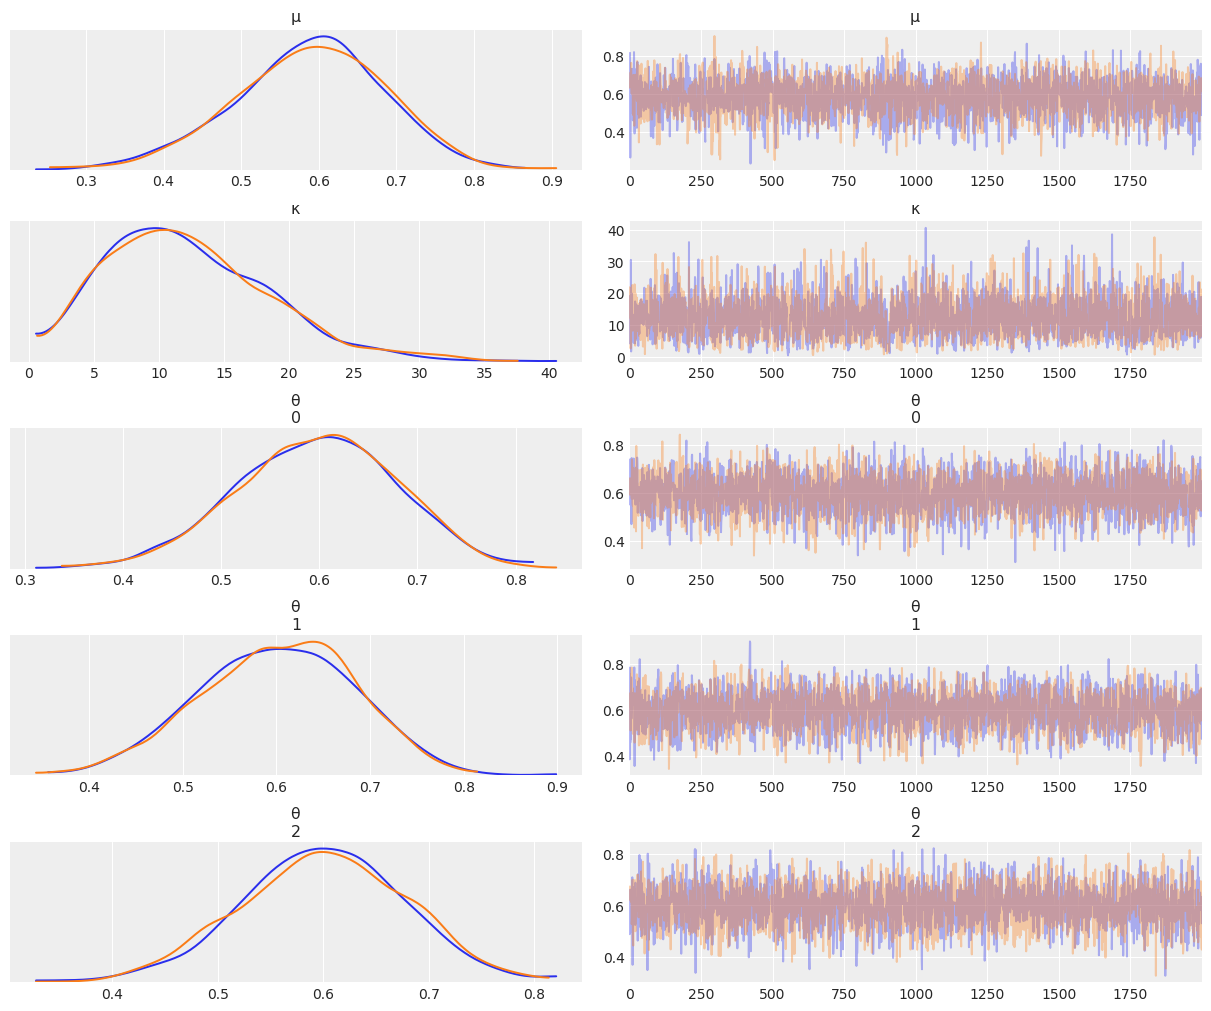

In [39]:
az.plot_trace(trace_h)
plt.savefig('B11197_02_20.png', dpi=300)

In [40]:
#az.summary(trace_h) #[18, 18, 18] 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.587,0.097,0.395,0.757,0.002,0.001,2745.0,2698.0,2736.0,2177.0,1.0
κ,12.260,6.217,2.003,23.371,0.125,0.088,2477.0,2477.0,2042.0,1744.0,1.0
θ[0],0.596,0.081,0.438,0.737,0.001,0.001,3777.0,3777.0,3778.0,2990.0,1.0
θ[1],0.600,0.082,0.443,0.745,0.002,0.001,2830.0,2794.0,2807.0,2539.0,1.0
θ[2],0.599,0.077,0.444,0.733,0.001,0.001,3236.0,3229.0,3228.0,2544.0,1.0


In [46]:
#az.summary(trace_h) #[3, 3, 3] 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.163,0.076,0.042,0.302,0.002,0.001,2376.0,2313.0,2411.0,2655.0,1.0
κ,11.616,6.324,1.023,22.657,0.115,0.081,3024.0,3024.0,2593.0,1817.0,1.0
θ[0],0.114,0.052,0.024,0.207,0.001,0.001,3137.0,2935.0,3031.0,2423.0,1.0
θ[1],0.114,0.052,0.026,0.211,0.001,0.001,3158.0,2994.0,3073.0,2361.0,1.0
θ[2],0.114,0.051,0.026,0.204,0.001,0.001,3112.0,3112.0,2859.0,2195.0,1.0


In [50]:
az.summary(trace_h) #[18, 3, 3] 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.298,0.112,0.107,0.514,0.002,0.002,2346.0,2239.0,2433.0,2385.0,1.0
κ,5.836,3.834,0.556,12.950,0.078,0.055,2445.0,2445.0,2159.0,2047.0,1.0
θ[0],0.552,0.088,0.385,0.711,0.002,0.001,2801.0,2801.0,2789.0,2558.0,1.0
θ[1],0.127,0.058,0.032,0.236,0.001,0.001,3410.0,3410.0,3127.0,1928.0,1.0
θ[2],0.128,0.058,0.029,0.236,0.001,0.001,3221.0,3221.0,3052.0,2438.0,1.0


我们的估算值朝着共同的均值缩水了。 这完全可以，确实这只是我们模型的结果； 通过使用超级优先级，我们正在从数据中估计Beta先验分布的参数，并且每个组都在通知其余组，而其他组则通过其他组的估计来获知。 简而言之，这些组通过超优先级有效地共享信息。 结果，我们正在观察所谓的收缩。 这种影响是部分合并数据的结果。 我们正在对各个群体进行建模，它们既不是彼此独立，也不是单个大群体。 相反，我们中间有东西。

为什么这有用？因为具有收缩有助于更稳定的推断。从许多方面来看，这与我们在学生t分布和异常值中看到的相似，在这种模型中，我们使用重尾分布在模型中更加健壮或对远离均值的数据点的响应较弱。引入超优先级并因此在较高层次上进行推理会导致模型更加保守（可能是我第一次以一种讨人喜欢的方式使用保守性模型），该模型对单个组中的极端值反应较慢。为了说明这一点，假设每个邻域的样本大小不同，有些很小，有些更大。样本量越小，越容易获得假结果。在极端情况下，如果在给定的邻域中仅采样一个样本，则可能会碰到整个邻域中唯一真正古老的铅管，或者相反，可能是唯一由PVC制成的导管。在一种情况下，您会高估不良质量，而在另一种情况下，则会低估它。在分层模型下，将通过另一组提供的信息来减轻一个组的估计失误。当然，更大的样本量也可以解决问题，但是通常不是这样。

收缩量当然取决于数据。 具有更多数据的组比具有较少数据点的组更难以拉动其他组的估计。 如果几组是相似的，而一组是不同的，则相似的组将告知其他组它们的相似性并加强共同的估计，而他们将拉近相似性较低组的估计。 这正是我们在前面的示例中看到的。

超优先级还可以调节收缩量。 如果我们有关于组级分布的可靠信息，我们可以有效地使用信息，然后将我们的估计值缩小到合理的值。 没有什么可以阻止我们仅使用两个组来构建层次模型的，但是我们希望有多个组。 直观地，原因是收缩就像假设每个组都是一个数据点一样，我们正在估计组级别的标准偏差。 通常，除非我们有很强的先验能力来告知我们的估计，否则我们不相信数据点太少的估计。 对于分层模型，情况类似。

In [51]:
len(trace_h)

2000

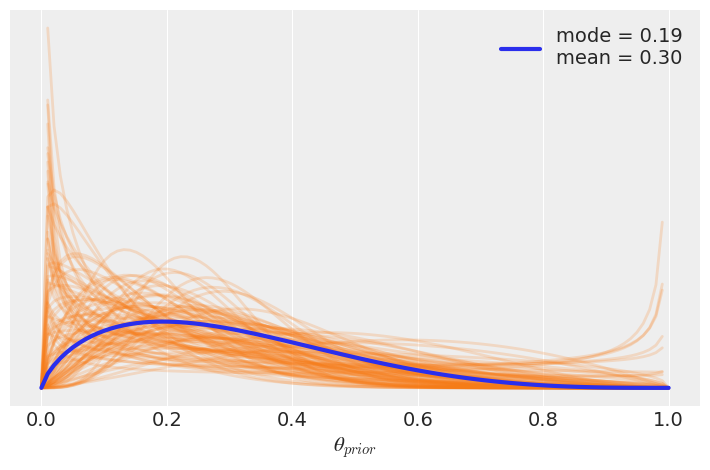

In [52]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]    #众数，而不是中间值
mean = dist.moment(1)         #Non-central moment of order n ;= dist.mean()
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [63]:
x[19]

0.19191919191919193

In [64]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

#### 非分层的版本

In [69]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:11<00:00, 269.90draws/s]


#### 分层版本

现在，我们将构建模型的分层版本。 我们添加了两个超优先级：一个是$\mu$的均值，另一个是$\mu$的标准差。 我们没有给$\delta$任何先决条件。 这只是一个模型选择。 我决定仅出于教学目的使用更简单的模型。 您可能会遇到一个似乎无法接受的问题，并且您可能认为有必要为$\delta$添加一个超级优先级； 随时这样做：

In [70]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:14<00:00, 213.34draws/s]


我们将使用ArviZ的plot_forest函数比较结果。 我们可以将多个模型传递给该函数。 当我们想比较来自不同模型的参数值（例如本示例）时，这很有用。 请注意，我们正在将多个参数传递给plot_forest以获取所需的绘图，例如Combined=True合并所有链中的结果。 我邀请您探索其余的论点：

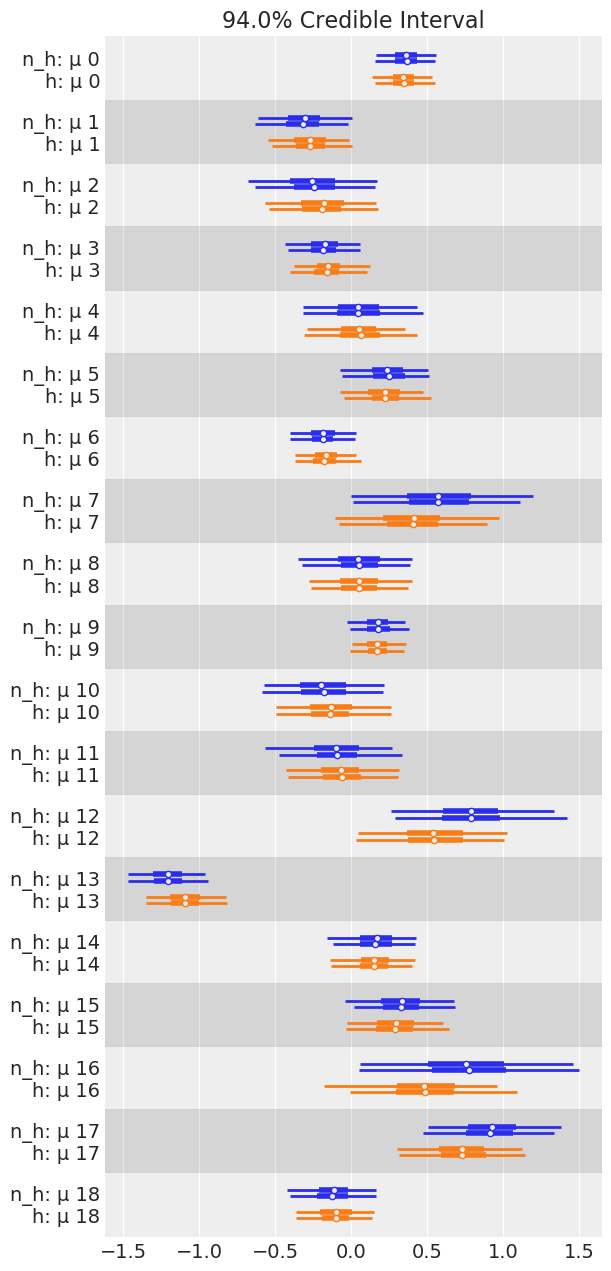

In [78]:
axes=az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')

In [79]:
axes[0].get_ylim()

(-2.7, 168.7500000000001)

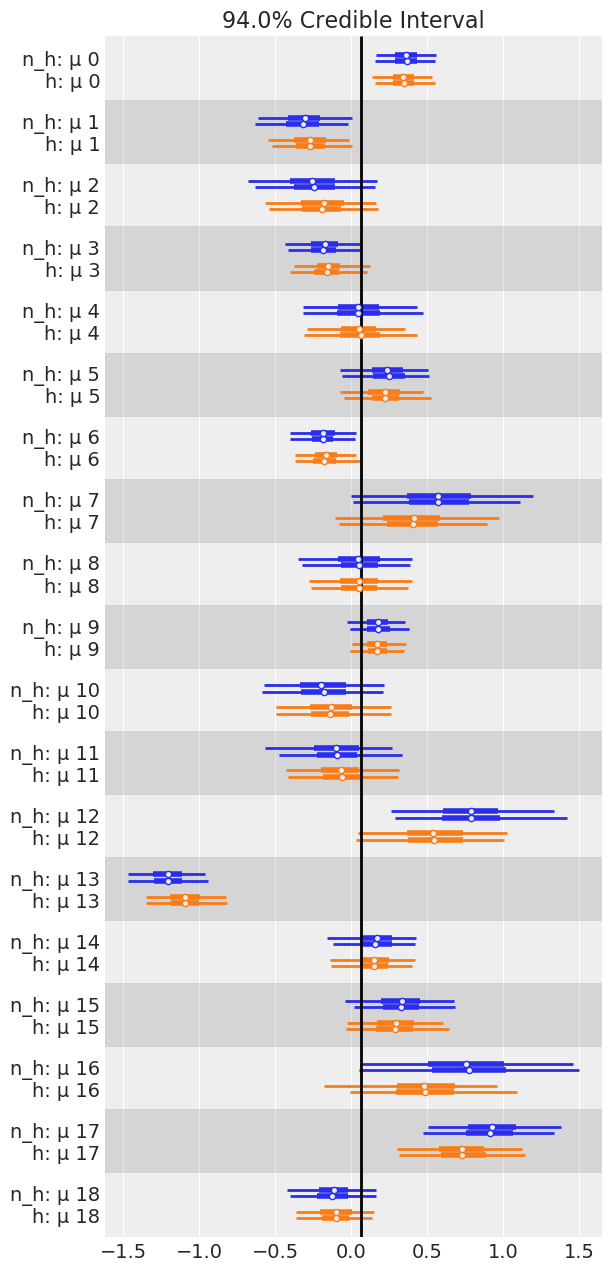

In [80]:
axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
                         #var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)

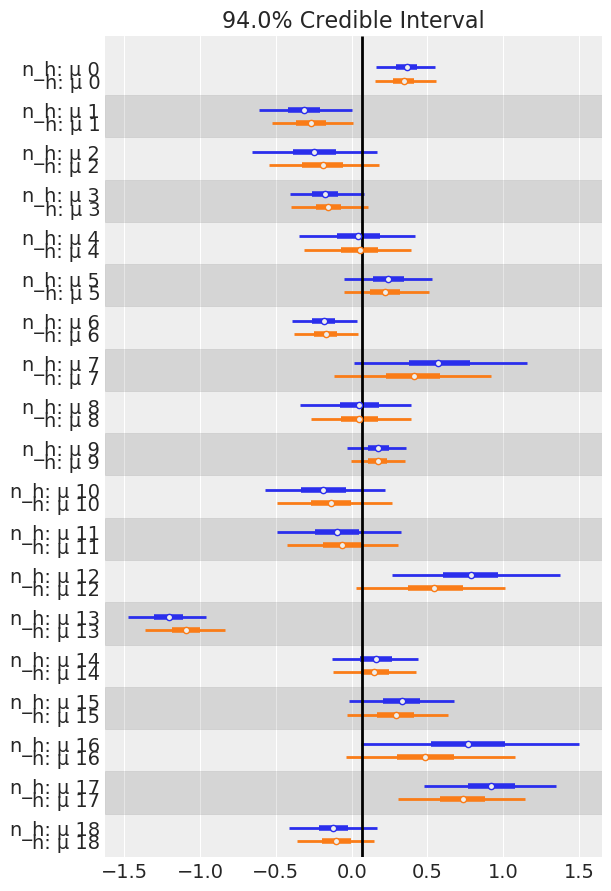

In [81]:
axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=True, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)

此图最相关的部分是，将层次模型的估算值推向部分合并的均值，或者等效地，相对于未合并的估算值，这些收缩了。 您还将注意到，对于远离均值（例如13）的那些组，其影响更为臭名昭著，并且不确定性与非分层模型的不确定性处于同一水平或更小。 因为我们对每个组都有一个估计，所以部分汇总了估计，但是各个组的估计通过超优先级相互限制。

可以肯定地说，用Python的禅道来解释，分层模型是一个很棒的主意-让我们做更多的事情！ 在接下来的章节中，我们将继续构建分层模型，并学习如何使用它们来构建更好的模型。 我们还将在第5章“模型比较”中讨论层次结构模型如何与统计和机器学习中普遍存在的过拟合/欠拟合问题相关。 在第8章“推理引擎”中，我们将讨论从分层模型进行采样时可能会发现的一些技术问题，以及如何诊断和解决这些问题。

这种部分合并的主要效果是，每个子组的估计将因其余子组的估计而有偏差。这种效应被称为收缩，通常是一个非常有用的技巧，它可以通过使推理更加保守（因为每个子组通过将估算值推向其他子组来告知其他子组）并提供更多信息来帮助改善推理。我们在子组级别和组级别获得估计。在接下来的章节中，我们将看到更多的层次模型示例。每个示例都将帮助我们从稍微不同的角度更好地理解它们。